In [2]:
from osgeo import gdal, gdal_array
import numpy as np
import os
from terracatalogueclient import Catalogue 
from shapely.geometry import Polygon
import geopandas as gpd
from shapely.geometry import box
import requests
from tqdm.auto import tqdm  # provides a progressbar
from pathlib import Path
import matplotlib.pyplot as plt
from pystac_client import Client
from odc.stac import configure_rio, stac_load
import os

In [3]:
# Ask the user to select an option
print('Please select the pilot area:')
print('0. GLOBAL')
print('1. COL')
print('2. CHAD')
print('3. IRAQ Dahuk')
print('4. IRAQ Najaf')
print('5. IRAQ')
print('6. LBN')
print('7. VEN')
print('9. SOM')
print('10. BGD')

pilot = input()
assert pilot in ['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], "Invalid pilot area selected."

Please select the pilot area:
0. GLOBAL
1. COL
2. CHAD
3. IRAQ Dahuk
4. IRAQ Najaf
5. IRAQ
6. LBN
7. VEN
9. SOM
10. BGD


 9


In [4]:
if pilot == "0":
    #input_shp = "C:/Geotar/COL/geodata/Processed/Education/Education_facilities.shp"
    pilot_name = "GLOBAL"
    mask_shp = f"C:/Geotar/{pilot_name}/geodata/workspace/test_mask.shp"
    period = "2021-05-01/2022-01-31"
    #output = f"C:/Geotar/COL/geodata/Processed/{res_folder}/dist_"+ out_name
    print("You selected GLobal")
elif pilot == "1":
    #input_shp = "C:/Geotar/COL/geodata/Processed/Education/Education_facilities.shp"
    pilot_name = "COL"
    mask_shp = f"C:/Geotar/{pilot_name}/geodata/Processed/Mask/COL_mask.shp"
    period = "2021-05-01/2022-01-31"
    #output = f"C:/Geotar/COL/geodata/Processed/{res_folder}/dist_"+ out_name
    print("You selected Colombia")
elif pilot == "2":
    pilot_name = "CHAD"
    #input_shp = "zip://C:/Geotar/CHAD/geodata/Processed/Education/hotosm_chad_education_facilities_points_shp.zip/hotosm_chad_education_facilities_points.shp"
    mask_shp = f"C:/Geotar/{pilot_name}/geodata/Processed/Mask/Chad_mask.shp"
    period = "2022-05-01/2023-01-31"
    #periodlta = "1970-01-01/1970-12-31"
    #output = f"C:/Geotar/CHAD/geodata/Processed/{res_folder}/dist_{res_folder}_"+ out_name
    print("You selected CHAD")
elif pilot == "3":
    pilot_name = "IRAQ_D"
    #input_shp = "zip://C:/Geotar/IRAQ_D/geodata/Raw/Education/hotosm_irq_education_facilities_points_shp.zip/hotosm_irq_education_facilities_points.shp"
    mask_shp = f"C:/Geotar/{pilot_name}/geodata/Processed/Mask/Dahuk_mask.shp"
    period = "2021-11-01/2022-05-31"
    #output = f"C:/Geotar/IRAQ_D/geodata/Processed/{res_folder}/dist_"+ out_name
    print("You selected IRAQ Dahuk")
elif pilot == "4":
    pilot_name = "IRAQ_N"
    period = "2021-11-01/2022-05-31"
    #input_shp = "zip://C:/Geotar/IRAQ_N/geodata/Raw/Education/hotosm_irq_education_facilities_points_shp.zip/hotosm_irq_education_facilities_points.shp"
    mask_shp = f"C:/Geotar/{pilot_name}/geodata/Processed/Mask/Najaf_mask.shp"
    #output = f"C:/Geotar/IRAQ_N/geodata/Processed/{res_folder}/dist_"+ out_name
    print("You selected IRAQ Najaf")
elif pilot == "5":
    pilot_name = "IRAQ"
    period = "2021-11-01/2022-05-31"
    #input_shp = "zip://C:/Geotar/IRAQ_N/geodata/Raw/Education/hotosm_irq_education_facilities_points_shp.zip/hotosm_irq_education_facilities_points.shp"
    mask_shp = f"C:/Geotar/{pilot_name}/geodata/Processed/Mask/Iraq_mask.shp"
    #output = f"C:/Geotar/IRAQ_N/geodata/Processed/{res_folder}/dist_"+ out_name
    print("You selected IRAQ")
elif pilot == "6":
    pilot_name = "LBN"
    period = "2021-10-01/2022-04-30"
    #input_shp = "zip://C:/Geotar/IRAQ_N/geodata/Raw/Education/hotosm_irq_education_facilities_points_shp.zip/hotosm_irq_education_facilities_points.shp"
    mask_shp = f"C:/Geotar/{pilot_name}/geodata/Processed/Mask/LBN_mask.shp"
    #output = f"C:/Geotar/IRAQ_N/geodata/Processed/{res_folder}/dist_"+ out_name
    print("You selected Lebanon")
elif pilot == "7":
    pilot_name = "VEN"
    period = "2023-01-01/2023-07-30"
    #input_shp = "zip://C:/Geotar/IRAQ_N/geodata/Raw/Education/hotosm_irq_education_facilities_points_shp.zip/hotosm_irq_education_facilities_points.shp"
    mask_shp = f"C:/Geotar/{pilot_name}/geodata/Processed/Mask/VEN_mask.shp"
    #output = f"C:/Geotar/IRAQ_N/geodata/Processed/{res_folder}/dist_"+ out_name
    print("You selected Venezuela")
elif pilot == "8":
    pilot_name = "AFG"
    period = "2023-04-01/2023-07-30"
    #input_shp = "zip://C:/Geotar/IRAQ_N/geodata/Raw/Education/hotosm_irq_education_facilities_points_shp.zip/hotosm_irq_education_facilities_points.shp"
    mask_shp = f"C:/Geotar/{pilot_name}/geodata/Processed/Mask/{pilot_name}_mask.shp"
    #output = f"C:/Geotar/IRAQ_N/geodata/Processed/{res_folder}/dist_"+ out_name
    print("You selected Afghanistan")
elif pilot == "9":
    pilot_name = "SOM"
    period = "2023-04-01/2023-07-30"
    #input_shp = "zip://C:/Geotar/IRAQ_N/geodata/Raw/Education/hotosm_irq_education_facilities_points_shp.zip/hotosm_irq_education_facilities_points.shp"
    mask_shp = f"C:/Geotar/{pilot_name}/geodata/Processed/Mask/{pilot_name}_mask.shp"
    #output = f"C:/Geotar/IRAQ_N/geodata/Processed/{res_folder}/dist_"+ out_name
    print("You selected Somalia")
elif pilot == "10":
    pilot_name = "BGD"
    period = "2023-04-01/2023-07-30"
    #input_shp = "zip://C:/Geotar/IRAQ_N/geodata/Raw/Education/hotosm_irq_education_facilities_points_shp.zip/hotosm_irq_education_facilities_points.shp"
    mask_shp = f"C:/Geotar/{pilot_name}/geodata/Processed/Mask/{pilot_name}_mask.shp"
    #output = f"C:/Geotar/IRAQ_N/geodata/Processed/{res_folder}/dist_"+ out_name
    print("You selected Bangladesh")

You selected Somalia


In [5]:
area_shp = gpd.read_file(mask_shp)

# Get the bounding box of the shapefile
bbox = area_shp.total_bounds
bbox

array([40.39407136, -1.92483662, 51.58562142, 13.63884234])

In [6]:
# define the output folder path
output_folder = f"C:/Geotar/{pilot_name}/geodata/Processed/LandCover/tiles"  
# use current directory or set a different one to store downloaded files
# create the directory if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [7]:
# get AOI geometry (select a country name)
#country = 'Somalia'

In [8]:

s3_url_prefix = "https://esa-worldcover.s3.eu-central-1.amazonaws.com"

# load natural earth low res shapefile
#ne = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

#geom = ne[ne.name == country].iloc[0].geometry

# Define the bounding box coordinates: [minx, miny, maxx, maxy]
#bbox = [40.39407136, -1.92483662, 51.58562142, 13.63884234]

# Create a GeoDataFrame with a single geometry representing the bounding box
geom1 = gpd.GeoDataFrame(geometry=[box(bbox[0], bbox[1], bbox[2], bbox[3])], crs='EPSG:4326')
geom1= geom1.geometry.iloc[0]

# load worldcover grid
url = f'{s3_url_prefix}/esa_worldcover_grid.geojson'
#print(url)
grid = gpd.read_file(url)

# get grid tiles intersecting AOI
tiles = grid[grid.intersects(geom1)]
#tiles = gpd.overlay(grid, geom1, how='intersection')


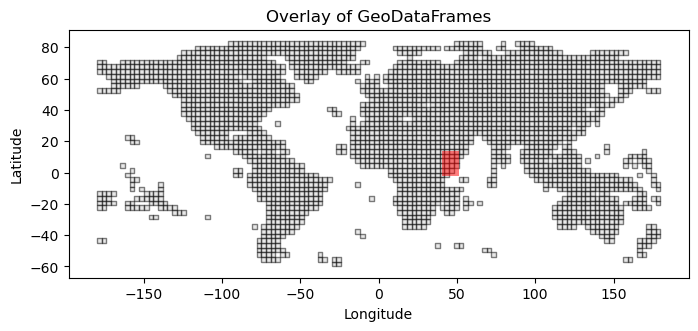

In [9]:

# Plot both GeoDataFrames on the same figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the grid GeoDataFrame
grid.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)

# Create a GeoSeries containing the Polygon object
geoms = gpd.GeoSeries([geom1])

# Create a GeoDataFrame from the GeoSeries
gdfplot = gpd.GeoDataFrame(geometry=geoms)

# Plot the bounding box GeoDataFrame
gdfplot.plot(ax=ax, color='red', alpha=0.5)

# Customize the plot as needed
ax.set_title("Overlay of GeoDataFrames")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

In [10]:

year = 2021  # setting this to 2020 will download the v100 product instead

# select version tag, based on the year
version = {2020: 'v100',
           2021: 'v200'}[year]

for tile in tqdm(tiles.ll_tile):
    url = f"{s3_url_prefix}/{version}/{year}/map/ESA_WorldCover_10m_{year}_{version}_{tile}_Map.tif"
    out_fn = Path(output_folder) / Path(url).name
    if not out_fn.exists():
        r = requests.get(url, allow_redirects=True)
        with open(out_fn, 'wb') as f:
            f.write(r.content)

  0%|          | 0/23 [00:00<?, ?it/s]

## Create reference raster from MODIS stored in HDC

In [ ]:
TOKEN_PATH = "C:/Users/oscar.bautista/OneDrive - World Food Programme/Scripts/tk.json"
HDC_STAC_URL= "https://api.earthobservation.vam.wfp.org/stac/"


def _get_hdc_stac_param_from_env():
    
    if "JUPYTERHUB_USER" in os.environ:
    
        signer = None
        header = None
        aws={}   # Get credentials for accessing S3 bucket 

    else:

        def make_signer(fname="./tk.json"):
            """
            Loads token from file at fname, and returns a function patching request urls with said token
            """
            tk = ""
            with open(fname, "rt") as src:
                tk = json.load(src)["tk"]

            def sign(url, _tk=tk):
                signed = f"{url}?{_tk}"
                return signed

            return sign

        signer = make_signer(TOKEN_PATH)
        header = {"origin": "https://wfp.org"}
        aws = None
        
    # Instantiate an API client pointing to the WFP HDC STAC API
    hdc_stac_client = Client.open(HDC_STAC_URL, headers=header)
    
    # Set up GDAL/rasterio configuration.
    configure_rio(cloud_defaults=True, verbose=True, aws=aws)
        
    return hdc_stac_client, signer


#
# STAC CLIENTS
#

hdc_stac_client, signer = _get_hdc_stac_param_from_env() 

In [ ]:
%%time
NDVI = hdc_stac_client.search(bbox=bbox,
    #collections=["mod13q1_vim_native"],
    collections=["mxd13q1_vim_dekad"],
    datetime="2018-04-01/2018-04-30", #emulates the period of data cube files
).get_all_items()

res = 0.0022457882102988 # 250 or 0.01 for 1km
ndvi_stack = stac_load(NDVI,  output_crs='EPSG:4326', resolution= res, patch_url=signer, bbox=bbox)
ndvi_stack

In [ ]:
ndvi = ndvi_stack.mean(dim=["month"])

In [ ]:
output_dir_s = f"C:/Geotar/{pilot_name}/geodata/Processed/mask"
filename_mod = f'{output_dir_s}/MODIS_mask.tif'
if not os.path.exists(output_dir_s):
    os.makedirs(output_dir_s)

# write the data to a geotiff file
ndvi_m_s.rio.to_raster(filename_mod, driver='GTiff')
print(f"{filename_mod} saved successfully")

In [ ]:
# Define the reference raster
ref_tiff = filename_mod

In [ ]:
def WorldcovertoMODIS(dst_file,tiffs_path, ref_tif):
    '''Function to mosaic the tiff files downloaded from the worldcover dataset AWS bucket
    Inputs are:
    1. the output tiff path
    2. path to the tiled tif files
    3. NDVI MODIS processed file
    '''
    # List all TIFF files in the working directory with complete file paths
    tiffslist = [os.path.join(tiffs_path, f) for f in os.listdir(tiffs_path) if f.endswith('.tif')]
    print("Files available: ")

    for i in tiffslist:
        print(i)
        
    def get_extent(ref_tif):
        dataset = gdal.Open(ref_tif)
        if dataset is None:
            print("Failed to open the raster file.")
            return None

        # Get geotransform information
        geotransform = dataset.GetGeoTransform()
        if geotransform is None:
            print("Failed to get geotransform information.")
            return None

        # Extract extent
        minX = geotransform[0]
        maxY = geotransform[3]
        maxX = minX + geotransform[1] * dataset.RasterXSize
        minY = maxY + geotransform[5] * dataset.RasterYSize
    
        # Extract x and y resolutions
        xRes = abs(geotransform[1])
        yRes = abs(geotransform[5])

        return minX, minY, maxX, maxY, xRes, yRes
    minX, minY, maxX, maxY, xRes, yRes = get_extent(ref_tif)
    #keyword arguments that define extent and pixel size, these match the footprint og the modis ndvi data
    kwargs={'format': 'GTiff',
        'outputBounds':[minX, minY, maxX, maxY],
        'outputBoundsSRS':'EPSG:4326',
        'xRes':xRes,
        'yRes':yRes,
        'width':4984,
        'height':6932,
           }
    #warp opetation
    gdal.Warp(dst_file, tiffslist, **kwargs)
    dst_file= None
    print(mosaic_file_tif, "processed successfully")

In [ ]:
WorldcovertoMODIS(mosaic_file_tif, output_folder, ref_tiff)

In [12]:
import shutil
shutil.rmtree(output_folder)